# Setup

In [6]:
# do this before anything else because you don't want to have to rerun this 
# every time you need to install something new - pain in the ass

# Install Earth Engine API
!pip install -q earthengine-api 

# import ee
import ee
# from ee.oauth import get_credentials_path
# print(get_credentials_path())

# Authenticate Earth Engine
ee.Authenticate(force=True)
print('GEE authenticated')

Enter verification code:  4/1Ab32j91Kkci-Ak-9Gu4ie7xLpokj1l684mcJLdmDKVrWrve-bMNFUT1nnkU



Successfully saved authorization token.
GEE authenticated


In [7]:
# Initialize Earth Engine
ee.Initialize(project='columbia-phd')
print('GEE initialized')

# import whatever else you need
from datetime import datetime
import os
import rasterio
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap
# GEEmap for visualization
!pip install -q geemap
# !pip install -q ipywidgets geemap
# !pip install -q ipywidgets geemap jupyterlab_widgets
import geemap
print('GEE imported')

GEE initialized
GEE imported


In [21]:
# import data

# AOI 
# -----------------------------------------------------------------------------------------------------

# faoFC = ee.FeatureCollection("FAO/GAUL/2015/level2")
# aoiFC = faoFC.filter(ee.Filter.eq('ADM1_NAME', 'Madre de Dios'))
# print(aoiFC)

square = ee.Feature(
    ee.Geometry.Polygon([
        [[-73.489604265885, -9.106738678620076],
          [-73.489604265885, -14.471148538041154],
          [-67.72178200026, -14.471148538041154],
          [-67.72178200026, -9.106738678620076]]
    ])
)

aoiFC = ee.FeatureCollection([square])

# TerraClim
# -----------------------------------------------------------------------------------------------------

# https://developers.google.com/earth-engine/datasets/catalog/IDAHO_EPSCOR_TERRACLIMATE
terraClimIC = (
    ee.ImageCollection('IDAHO_EPSCOR/TERRACLIMATE')
    .filter(ee.Filter.date('2000-01-01', '2024-12-31'))
    .select(['tmmx', 'tmmn', 'pr','pdsi','def','vpd','soil'])
    .map(lambda img: img.clip(aoiFC))
)
# print(terraClimIC)

res = terraClimIC.first().projection().nominalScale().getInfo()

# print pixel size
print('pixel size:', res) 
print('band names:', terraClimIC.first().bandNames().getInfo())

pixel size: 4638.312116386398
band names: ['tmmx', 'tmmn', 'pr', 'pdsi', 'def', 'vpd', 'soil']


In [22]:
# scale values according to Terraclim metadata

# define scaling factors for each band
scales = {
    'tmmx': 0.1,
    'tmmn': 0.1,
    'pr': 1,
    'pdsi': 0.01,
    'def': 0.1,
    'vpd': 0.01,
    'soil': 0.1
}

# define a function that scales each band in an image
def scale_bands(img):
    
    # Multiply each band by its scale
    scaled = img.select(list(scales.keys())) \
                .multiply(ee.Image.constant(list(scales.values())))
    
    # Preserve band names
    scaled = scaled.rename(list(scales.keys()))
    
    return scaled.copyProperties(img, img.propertyNames())

# Apply to the collection
terraClimIC_scaled = terraClimIC.map(scale_bands)

In [24]:
# Create map
m = geemap.Map()
m.centerObject(aoiFC, zoom=7)

# get min and max values for visualization
terraClim_mean = terraClimIC_scaled.median()
minMaxStats = terraClim_mean.reduceRegion(
    reducer=ee.Reducer.minMax(),
    geometry=aoiFC,          
    scale=res,              
    maxPixels=1e13
)

print(minMaxStats.getInfo())
print(minMaxStats.get('tmmx_min').getInfo())
print(minMaxStats.get('tmmx_max').getInfo())

# define visualization parameters
palette = [
        '1a3678', '2955bc', '5699ff', '8dbae9', 'acd1ff', 'caebff', 'e5f9ff',
        'fdffb4', 'ffe6a2', 'ffc969', 'ffa12d', 'ff7c1f', 'ca531a', 'ff0000',
        'ab0000'
    ]

# add to map
m.addLayer(aoiFC, {}, "AOI")
m.addLayer(terraClim_mean.select('tmmx'), 
           {'min': minMaxStats.get('tmmx_min'),
            'max': minMaxStats.get('tmmx_max'),
            'palette':palette}, 
           "Max temp")
m.addLayer(terraClim_mean.select('tmmn'), 
           {'min': minMaxStats.get('tmmn_min'),
            'max': minMaxStats.get('tmmn_max'),
            'palette':palette}, 
           "Min temp")
m.addLayer(terraClim_mean.select('pdsi'), 
           {'min': minMaxStats.get('pdsi_min'),
            'max': minMaxStats.get('pdsi_max'),
            'palette':palette}, 
           "PDSI")
m.addLayer(terraClim_mean.select('vpd'), 
           {'min': minMaxStats.get('vpd_min'),
            'max': minMaxStats.get('vpd_max'),
            'palette':palette}, 
           "VPD")
m.addLayer(terraClim_mean.select('def'), 
           {'min': minMaxStats.get('def_min'),
            'max': minMaxStats.get('def_max'),
            'palette':palette}, 
           "Water deficit")
m.addLayer(terraClim_mean.select('pr'), 
           {'min': minMaxStats.get('pr_min'),
            'max': minMaxStats.get('pr_max'),
            'palette':palette}, 
           "Precip")
m.addLayer(terraClim_mean.select('soil'), 
           {'min': minMaxStats.get('soil_min'),
            'max': minMaxStats.get('soil_max'),
            'palette':palette}, 
           "Soil moisture")

m

{'def_max': 73.99000000000001, 'def_min': 0, 'pdsi_max': 2.2814285714285716, 'pdsi_min': -3.276666666666667, 'pr_max': 440.75, 'pr_min': 23, 'soil_max': 349.43333333333334, 'soil_min': 4.11, 'tmmn_max': 21.800000000000008, 'tmmn_min': -7.75, 'tmmx_max': 31.600000000000005, 'tmmx_min': 8.4, 'vpd_max': 1.18, 'vpd_min': 0.4100000000000001}
8.4
31.600000000000005


Map(center=[-11.794669076434946, -70.60569313307249], controls=(WidgetControl(options=['position', 'transparen…

In [26]:
# check dates
# terraClimIC_filtered = terraClimIC_scaled.filterDate('2010-01-01', '2010-12-31')
# print("Images in 2010:", terraClimIC_filtered.size().getInfo())

print(terraClimIC_scaled.size().getInfo())

years = ee.List.sequence(2000, 2024)

def count_by_year(y):
    y = ee.Number(y)
    fc = terraClimIC_scaled.filterDate(
        ee.Date.fromYMD(y, 1, 1),
        ee.Date.fromYMD(y.add(1), 1, 1)
    )
    return ee.Feature(None, {
        'year': y,
        'count': fc.size()
    })

summary = ee.FeatureCollection(years.map(count_by_year))
# print(summary.getInfo())

simple = summary.aggregate_array('year').zip(
    summary.aggregate_array('count')
).getInfo()

for yr, cnt in simple:
    print(yr, cnt)



300
2000 12
2001 12
2002 12
2003 12
2004 12
2005 12
2006 12
2007 12
2008 12
2009 12
2010 12
2011 12
2012 12
2013 12
2014 12
2015 12
2016 12
2017 12
2018 12
2019 12
2020 12
2021 12
2022 12
2023 12
2024 12


In [27]:
export_folder = "/home/jovyan/MLEAEEE4000-DroughtAmazon2/data/TerraClim"

collection = terraClimIC_scaled  # your processed ImageCollection

# Create EE list
ee_list = collection.toList(collection.size())

# Loop
for i in range(collection.size().getInfo()):
    image = ee.Image(ee_list.get(i))

    # Extract date
    time_start = image.get('system:time_start').getInfo()
    date = datetime.utcfromtimestamp(time_start / 1000)
    date_str = date.strftime('%Y_%m')

    out_path = os.path.join(export_folder, f"terraClim_{date_str}.tif")

    geemap.ee_export_image(
        image,
        filename=out_path,
        region=aoiFC.geometry(),
        scale=res,
    )

    print(f"Exported {out_path}")

Generating URL ...
Please wait ...
Data downloaded to /home/jovyan/MLEAEEE4000-DroughtAmazon2/data/TerraClim/terraClim_2000_01.tif
Exported /home/jovyan/MLEAEEE4000-DroughtAmazon2/data/TerraClim/terraClim_2000_01.tif
Generating URL ...
Please wait ...
Data downloaded to /home/jovyan/MLEAEEE4000-DroughtAmazon2/data/TerraClim/terraClim_2000_02.tif
Exported /home/jovyan/MLEAEEE4000-DroughtAmazon2/data/TerraClim/terraClim_2000_02.tif
Generating URL ...
Please wait ...
Data downloaded to /home/jovyan/MLEAEEE4000-DroughtAmazon2/data/TerraClim/terraClim_2000_03.tif
Exported /home/jovyan/MLEAEEE4000-DroughtAmazon2/data/TerraClim/terraClim_2000_03.tif
Generating URL ...
Please wait ...
Data downloaded to /home/jovyan/MLEAEEE4000-DroughtAmazon2/data/TerraClim/terraClim_2000_04.tif
Exported /home/jovyan/MLEAEEE4000-DroughtAmazon2/data/TerraClim/terraClim_2000_04.tif
Generating URL ...
Please wait ...
Data downloaded to /home/jovyan/MLEAEEE4000-DroughtAmazon2/data/TerraClim/terraClim_2000_05.tif
E

Band count: 7
Band descriptions: (None, None, None, None, None, None, None)
Metadata: {'driver': 'GTiff', 'dtype': 'float64', 'nodata': None, 'width': 139, 'height': 130, 'count': 7, 'crs': CRS.from_wkt('GEOGCS["Greenwich",DATUM["unnamed",SPHEROID["unnamed",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST]]'), 'transform': Affine(0.041666666666666664, 0.0, -73.5,
       0.0, -0.041666666666666664, -9.083333333333329)}


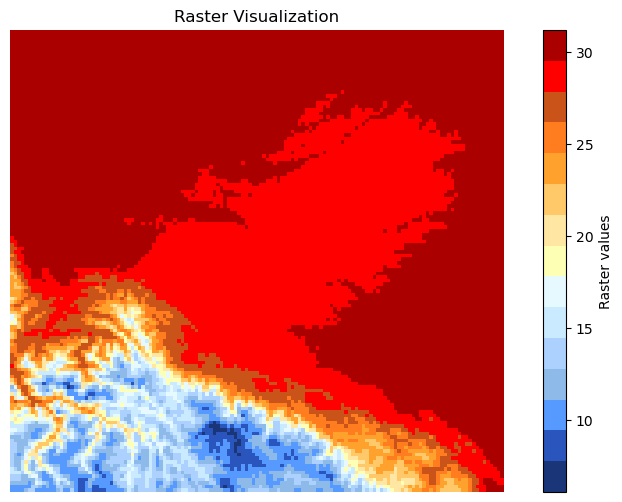

In [30]:
# check export
# Path to your raster
raster_path = "/home/jovyan/MLEAEEE4000-DroughtAmazon2/data/TerraClim/terraClim_2001_03.tif"
band_number = 1

# Open raster using rasterio
with rasterio.open(raster_path) as src:
    raster = src.read(1)          # read first band
    transform = src.transform      # georeference info (optional)
    nodata = src.nodata
    print("Band count:", src.count)
    print("Band descriptions:", src.descriptions)
    print("Metadata:", src.meta)
    

# Mask nodata values
raster = np.ma.masked_equal(raster, nodata)

# Define your color palette
palette = [
    '#1a3678', '#2955bc', '#5699ff', '#8dbae9', '#acd1ff', '#caebff', '#e5f9ff',
    '#fdffb4', '#ffe6a2', '#ffc969', '#ffa12d', '#ff7c1f', '#ca531a', '#ff0000',
    '#ab0000'
]

cmap = ListedColormap(palette)

# Visualize
plt.figure(figsize=(10, 6))
plt.imshow(raster, cmap=cmap)
plt.colorbar(label='Raster values')
plt.title('Raster Visualization')
plt.axis('off')
plt.show()

In [32]:
m = geemap.Map()
m.centerObject(aoiFC, zoom=7)

m.addLayer(terraClimIC_scaled
    .filter(ee.Filter.date('2001-03-01', '2001-03-31'))
    .select('tmmx')
    .first(), 
           {'min': 10,
            'max': 30,
            'palette':palette}, 
           "Max temp")

m

Map(center=[-11.794669076434946, -70.60569313307249], controls=(WidgetControl(options=['position', 'transparen…

Band count: 1
Band descriptions: (None,)
Metadata: {'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 0.0, 'width': 90, 'height': 86, 'count': 1, 'crs': CRS.from_wkt('GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]'), 'transform': Affine(0.04166666666666666, 0.0, -72.41666666666669,
       0.0, -0.04166666666666666, -9.791666666666643)}


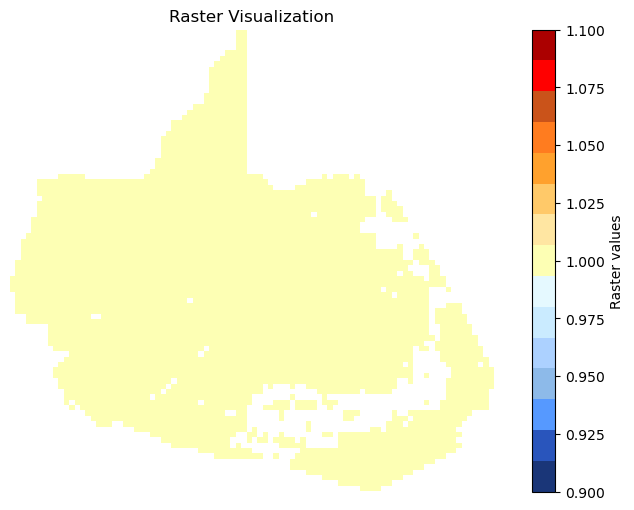

In [33]:
# check export
# Path to your raster
raster_path = "/home/jovyan/MLEAEEE4000-DroughtAmazon2/data/mdd_extent_TCscale.tif"
band_number = 1

# Open raster using rasterio
with rasterio.open(raster_path) as src:
    raster = src.read(1)          # read first band
    transform = src.transform      # georeference info (optional)
    nodata = src.nodata
    print("Band count:", src.count)
    print("Band descriptions:", src.descriptions)
    print("Metadata:", src.meta)
    

# Mask nodata values
raster = np.ma.masked_equal(raster, nodata)

# Define your color palette
palette = [
    '#1a3678', '#2955bc', '#5699ff', '#8dbae9', '#acd1ff', '#caebff', '#e5f9ff',
    '#fdffb4', '#ffe6a2', '#ffc969', '#ffa12d', '#ff7c1f', '#ca531a', '#ff0000',
    '#ab0000'
]

cmap = ListedColormap(palette)

# Visualize
plt.figure(figsize=(10, 6))
plt.imshow(raster, cmap=cmap)
plt.colorbar(label='Raster values')
plt.title('Raster Visualization')
plt.axis('off')
plt.show()